# Autoencoder for Molecular Property Prediction

## Learning Compressed Representations of Molecular Fingerprints

---

### Notebook Overview

This notebook demonstrates the application of **Autoencoders** for learning compressed representations of molecular fingerprints and predicting multiple molecular properties simultaneously. We use the QM9 dataset to train a model that compresses high-dimensional fingerprints into a lower-dimensional latent space while maintaining the ability to predict key molecular properties.

**Learning Objectives:**
- Understand autoencoder architecture and its components
- Learn the concept of latent space representation
- Implement encoder-decoder architecture in PyTorch
- Train autoencoders with dual objectives (reconstruction + prediction)
- Compress high-dimensional molecular fingerprints
- Predict multiple molecular properties from latent representations
- Evaluate reconstruction quality and prediction accuracy

**Dataset:** QM9 - Quantum mechanical calculations for small organic molecules

**Task:** Multi-task learning - Compress fingerprints and predict molecular properties

---

### What is an Autoencoder?

**Definition:**

An **autoencoder** is an unsupervised neural network that learns to compress data into a lower-dimensional representation (encoding) and then reconstruct the original data from this compressed form (decoding).

**Core Architecture:**

```
Input → Encoder → Latent Space → Decoder → Reconstruction
 (2048)   (layers)    (128)      (layers)     (2048)
```

**Three main components:**

**1. Encoder:**
- Compresses input to lower dimensions
- Learns meaningful features
- Example: 2048 → 512 → 256 → 128
- Output: Latent representation (bottleneck)

**2. Latent Space (Bottleneck):**
- Compressed representation of input
- Forces model to learn essential features
- Dimensionality reduction
- Can be used for downstream tasks

**3. Decoder:**
- Reconstructs input from latent space
- Mirror of encoder architecture
- Example: 128 → 256 → 512 → 2048
- Output: Reconstructed input

**Training Objective:**
```
Minimize: Loss(Input, Reconstructed_Input)
Goal: Reconstruction as close to original as possible
```

---

### Why Use Autoencoders for Molecules?

**Dimensionality Reduction:**

- Molecular fingerprints are high-dimensional (2048+ bits)
- Most bits are zeros (sparse)
- Autoencoder learns dense, low-dimensional representation
- Captures essential molecular features

**Feature Learning:**

- Unsupervised learning of molecular features
- Latent space captures chemical properties
- Similar molecules cluster together
- Useful for downstream tasks

**Multi-Task Learning:**

In this notebook, we extend the basic autoencoder:
- Task 1: Reconstruct fingerprints (unsupervised)
- Task 2: Predict molecular properties (supervised)
- Combined: Learn representations useful for both tasks

---

### Autoencoder vs Other Approaches

| Aspect | Autoencoder | PCA | Direct Prediction |
|--------|-------------|-----|-------------------|
| **Type** | Neural network | Linear | Neural network |
| **Learning** | Non-linear | Linear | Supervised |
| **Reconstruction** | Yes | Yes | No |
| **Flexibility** | High | Low | High |
| **Latent Space** | Learned | Fixed | N/A |
| **Use Case** | Compression + tasks | Quick compression | Task-specific |

**When to use autoencoders:**
- Need dimensionality reduction with non-linear relationships
- Want to learn general representations
- Have both labeled and unlabeled data
- Need to visualize high-dimensional data
- Want to detect anomalies (outliers)

---

### This Notebook's Approach

**Extended Autoencoder Architecture:**

```
Input Fingerprint (2048 bits)
        ↓
    Encoder Layers
        ↓
  Latent Space (128 dim) ─────→ Property Predictor → Properties (logP, etc.)
        ↓
    Decoder Layers
        ↓
Reconstructed Fingerprint
```

**Dual Loss Function:**
```
Total Loss = α × Reconstruction_Loss + β × Prediction_Loss
           = α × MSE(Input, Reconstructed) + β × MSE(True_Props, Pred_Props)
```

**Benefits of this approach:**
- Latent space learns features useful for property prediction
- Reconstruction ensures no information loss
- Single model for multiple tasks
- Efficient use of unlabeled molecular data

---

### QM9 Dataset

**Description:**
- Collection of ~134,000 small organic molecules
- Quantum mechanical calculations (DFT)
- Multiple molecular properties computed
- Standard benchmark in cheminformatics

**Properties we predict:**
- logP: Lipophilicity (drug-likeness)
- Molecular weight: Size of molecule
- Number of H-bond donors/acceptors
- Polar surface area: Membrane permeability
- Other physicochemical properties

---

## 1. Import Required Libraries

We import libraries for:
- **Deep Learning:** PyTorch (nn, optim, DataLoader)
- **Data Processing:** numpy, pandas
- **Chemistry:** RDKit (molecular operations, fingerprints, descriptors)
- **Visualization:** matplotlib, seaborn
- **Evaluation:** sklearn metrics
- **File Handling:** os, glob for dataset loading

**Key imports for autoencoders:**
- `torch.nn`: Neural network layers (Linear, ReLU, Sigmoid)
- `MSELoss`: Mean squared error for reconstruction
- `StandardScaler`: Normalize property values
- RDKit fingerprint generators

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Chemistry and Molecular Processing
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Crippen
from rdkit.Chem import rdFingerprintGenerator

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

---

## 2. Configuration Parameters

We define key hyperparameters for the autoencoder model and training process.

**Model Architecture Parameters:**

**Input Dimension:**
- Size of molecular fingerprint
- Morgan: 2048 bits (typical)
- MACCS: 166 bits
- Determines encoder input size

**Latent Dimension:**
- Size of compressed representation
- Bottleneck layer
- Typical values: 64, 128, 256
- Smaller = more compression, but potential information loss
- Larger = less compression, but retains more information
- Trade-off: Compression vs reconstruction quality

**Hidden Layer Dimensions:**
- Intermediate layers between input and latent space
- Example progression: 2048 → 1024 → 512 → 256 → 128
- Gradual dimensionality reduction
- Helps model learn hierarchical features

**Training Parameters:**

**Batch Size:**
- Number of molecules processed together
- Affects memory usage and training speed
- Typical values: 32, 64, 128

**Learning Rate:**
- Step size for optimization
- Typical values: 1e-3, 5e-4, 1e-4
- May need adjustment based on loss behavior

**Number of Epochs:**
- Training iterations through dataset
- Monitor validation loss for early stopping

**Loss Weights:**
- Alpha: Weight for reconstruction loss
- Beta: Weight for prediction loss
- Balances two objectives
- Example: α=0.5, β=0.5 (equal importance)
- Adjust based on task priority

In [2]:
# Configuration
DATA_FOLDER = 'qm9/'
MAX_FILES = None  # Set to a number (e.g., 10000) for faster testing, None for all files

# Fingerprint settings
FINGERPRINT_TYPE = 'morgan'  # Options: 'morgan', 'maccs', 'rdkit'
FINGERPRINT_RADIUS = 2
FINGERPRINT_BITS = 2048

# Model architecture
LATENT_DIM = 256

# Training parameters
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
ALPHA = 0.5  # Weight for reconstruction loss
BETA = 0.5   # Weight for property prediction loss
PATIENCE = 15  # Early stopping patience

# Data split
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---

## 3. Load QM9 Dataset

### 3.1 Define Properties to Calculate

We specify which molecular properties to extract from SMILES strings.

**Properties calculated:**
These are standard RDKit molecular descriptors used throughout drug discovery.

In [3]:
# Property names to calculate from molecules
target_properties = ['logP', 'logS']

print("Loading QM9 dataset from .xyz files...")
print(f"Target properties (calculated from RDKit): {target_properties}")
print("="*80)

Loading QM9 dataset from .xyz files...
Target properties (calculated from RDKit): ['logP', 'logS']


### 3.2 Load Molecular Data from Files

We load molecules from XYZ coordinate files and extract SMILES representations.

**File format:**
- .xyz files contain 3D coordinates
- SMILES string for 2D structure
- Properties already calculated in QM9

**Process:**
1. Scan directory for .xyz files
2. Parse each file
3. Extract SMILES string
4. Store in structured format

In [4]:
# Get list of all .xyz files
xyz_files = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith('.xyz')])

if MAX_FILES:
    xyz_files = xyz_files[:MAX_FILES]
    print(f"Using first {MAX_FILES} files for faster testing")
else:
    print(f"Using all {len(xyz_files)} files")

print(f"Total files to process: {len(xyz_files)}")

Using all 133885 files
Total files to process: 133885


### 3.3 Calculate Molecular Properties from SMILES

We calculate physicochemical properties for each molecule using RDKit.

**Calculation process:**
1. Convert SMILES to RDKit molecule object
2. Compute each descriptor
3. Handle invalid molecules (return None)
4. Store results in DataFrame

In [5]:
# Parse all .xyz files and calculate properties from SMILES
data_list = []

for xyz_file in tqdm(xyz_files, desc="Parsing .xyz files and calculating properties"):
    filepath = os.path.join(DATA_FOLDER, xyz_file)
    
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Extract SMILES string (second to last line, first element)
        smiles_line = lines[-2].strip().split('\t')
        smiles = smiles_line[0] if smiles_line else None
        
        if not smiles or pd.isna(smiles):
            continue
        
        # Convert SMILES to molecule
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        
        # Calculate properties using RDKit
        logP = Crippen.MolLogP(mol)  # Wildman-Crippen LogP
        # Estimated logS using simplified equation (Delaney ESOL-like approximation)
        logS = Descriptors.MolLogP(mol) - 0.74 * Descriptors.MolWt(mol)**0.5
        
        # Create property dictionary
        data = {
            'filename': os.path.basename(filepath),
            'smiles': smiles,
            'num_atoms': int(lines[0].strip()),
            'logP': logP,
            'logS': logS
        }
        
        data_list.append(data)
        
    except Exception as e:
        continue

# Create DataFrame
df = pd.DataFrame(data_list)

print(f"\nLoaded {len(df)} molecules successfully")
print(f"Dataset shape: {df.shape}")

Parsing .xyz files and calculating properties: 100%|██████████| 133885/133885 [00:27<00:00, 4815.15it/s]


Loaded 133885 molecules successfully
Dataset shape: (133885, 5)


### 3.4 Display Sample Data

Examine a few molecules to verify data loading and property calculation.

In [6]:
# Display sample data
df.head()

,filename,smiles,num_atoms,logP,logS
0,dsgdb9nsd_000001.xyz,C,5,0.63610,-2.327875
1,dsgdb9nsd_000002.xyz,N,4,0.16200,-2.891879
2,dsgdb9nsd_000003.xyz,O,3,-0.82470,-3.965562
3,dsgdb9nsd_000004.xyz,C#C,4,0.24940,-3.526631
4,dsgdb9nsd_000005.xyz,C#N,3,0.13978,-3.707224


### 3.5 Property Descriptions

Understanding what each molecular property represents:

**logP (Partition Coefficient):**
- Measures lipophilicity (oil vs water preference)
- Higher values = more lipophilic
- Important for drug absorption
- Typical drug range: 0-5

**MolWt (Molecular Weight):**
- Sum of atomic masses
- Affects bioavailability
- Lipinski's rule: < 500 Da for drugs

**NumHDonors (H-Bond Donors):**
- -OH and -NH groups
- Affects solubility
- Lipinski's rule: ≤ 5

**NumHAcceptors (H-Bond Acceptors):**
- Nitrogen and oxygen atoms
- Influences protein binding
- Lipinski's rule: ≤ 10

**TPSA (Topological Polar Surface Area):**
- Sum of polar atom surfaces
- Predicts membrane permeability
- BBB penetration: < 90 Ų

**NumRotatableBonds:**
- Molecular flexibility
- Affects binding
- Veber's rule: ≤ 10

In [7]:
# Remove rows with missing SMILES
df = df.dropna(subset=['smiles'])
print(f"Dataset shape after removing missing SMILES: {df.shape}")

# Display property statistics
print("\nProperty statistics:")
df[target_properties].describe()

Dataset shape after removing missing SMILES: (133885, 5)

Property statistics:


,logP,logS
count,133885.000000,133885.000000
mean,0.297389,-7.897485
std,1.000678,1.062294
min,-4.909700,-13.342850
25%,-0.349300,-8.582619
50%,0.281620,-7.902203
75%,0.946700,-7.209609
max,3.756900,-2.327875


---

## 4. Generate Molecular Fingerprints

We convert SMILES strings into numerical fingerprint representations.

**Fingerprint Types:**

**Morgan Fingerprints:**
- Circular fingerprints (ECFP-like)
- Configurable radius and size
- Captures local atomic environments
- Typical: radius=2, size=2048

**MACCS Keys:**
- 166 predefined structural features
- Interpretable substructures
- Lower dimensional
- Good for small molecules

**Why fingerprints for autoencoders?**
- Fixed-length vectors required for neural networks
- Binary representation easy to reconstruct
- Captures structural information
- Sparse, benefits from compression

In [8]:
print(f"Generating {FINGERPRINT_TYPE} fingerprints...")
print(f"Fingerprint size: {FINGERPRINT_BITS} bits")
print("="*80)

Generating morgan fingerprints...
Fingerprint size: 2048 bits


### 4.1 Generate Fingerprints for All Molecules

We apply fingerprint generation to the entire dataset.

**Process:**
1. For each SMILES string
2. Convert to molecule object
3. Generate fingerprint
4. Convert to numpy array
5. Handle failures gracefully

In [9]:
# Generate fingerprints for all molecules
fingerprints = []
valid_indices = []

# Create Morgan fingerprint generator (modern API)
if FINGERPRINT_TYPE == 'morgan':
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=FINGERPRINT_RADIUS, fpSize=FINGERPRINT_BITS)

for idx, smiles in enumerate(tqdm(df['smiles'], desc="Generating fingerprints")):
    if pd.isna(smiles):
        continue
    
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        
        # Generate fingerprint based on type
        if FINGERPRINT_TYPE == 'morgan':
            fp = morgan_gen.GetFingerprint(mol)
        elif FINGERPRINT_TYPE == 'maccs':
            fp = MACCSkeys.GenMACCSKeys(mol)
        elif FINGERPRINT_TYPE == 'rdkit':
            fp = Chem.RDKFingerprint(mol, fpSize=FINGERPRINT_BITS)
        else:
            raise ValueError(f"Unknown fingerprint type: {FINGERPRINT_TYPE}")
        
        fingerprints.append(np.array(fp))
        valid_indices.append(idx)
        
    except Exception as e:
        continue

# Convert to numpy array

fingerprints = np.array(fingerprints)
print(f"Fingerprints shape: {fingerprints.shape}")

print(f"\nGenerated {len(fingerprints)} valid fingerprints")

Generating fingerprints: 100%|██████████| 133885/133885 [02:41<00:00, 827.24it/s]


Fingerprints shape: (133885, 2048)

Generated 133885 valid fingerprints


In [10]:
# Filter dataframe to keep only valid molecules
df_clean = df.iloc[valid_indices].reset_index(drop=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Valid molecules: {len(df_clean)}")

Clean dataset shape: (133885, 5)
Valid molecules: 133885


---

## 5. Prepare Target Properties and Normalize

### 5.1 Extract Target Properties

We extract the molecular properties that the model will predict.

**Properties as targets:**
- Each property is a regression target
- Multi-task learning: predict all simultaneously
- From latent representation

In [11]:
# Extract target properties
properties = df_clean[target_properties].values

print(f"Properties shape: {properties.shape}")
print(f"Number of properties: {len(target_properties)}")
print(f"Property names: {target_properties}")

Properties shape: (133885, 2)
Number of properties: 2
Property names: ['logP', 'logS']


### 5.2 Normalize Property Values

We normalize properties to have zero mean and unit variance.

**Why normalize?**
- Properties have different scales (logP: -3 to 7, MolWt: 50-500)
- Neural networks train better with normalized inputs
- Prevents large-scale properties from dominating loss
- Standard practice in deep learning

**StandardScaler:**
```
Normalized = (Original - Mean) / Std
```

**Important:**
- Fit scaler on training data only
- Apply same transformation to validation and test
- Prevents data leakage
- Inverse transform for final predictions

In [12]:
# Normalize properties using StandardScaler
scaler_y = StandardScaler()
properties_scaled = scaler_y.fit_transform(properties)

print("\nProperties normalized using StandardScaler")
print(f"Mean after scaling: {properties_scaled.mean(axis=0)}")
print(f"Std after scaling: {properties_scaled.std(axis=0)}")


Properties normalized using StandardScaler
Mean after scaling: [-5.09482785e-17  5.94396582e-18]
Std after scaling: [1. 1.]


---

## 6. Split Data into Train, Validation, and Test Sets

We create three separate datasets for proper model evaluation.

**Three-way split:**

**Training Set (70%):**
- Used to update model weights
- Model learns from this data

**Validation Set (15%):**
- Monitor training progress
- Tune hyperparameters
- Early stopping based on this
- Not used for weight updates

**Test Set (15%):**
- Final evaluation only
- Never seen during training
- Unbiased performance estimate

**Why three sets?**
- Prevents overfitting
- Honest performance evaluation
- Validation guides training decisions
- Test measures generalization

In [13]:
# First split: separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    fingerprints, properties_scaled, 
    test_size=TEST_SPLIT, 
    random_state=42
)

# Second split: separate train and validation
val_size_adjusted = VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_adjusted,
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(fingerprints)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(fingerprints)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(fingerprints)*100:.1f}%)")
print(f"\nTotal: {len(fingerprints)} samples")

Training set: 107107 samples (80.0%)
Validation set: 13389 samples (10.0%)
Test set: 13389 samples (10.0%)

Total: 133885 samples


---

## 7. Create PyTorch Datasets and DataLoaders

### 7.1 Define Custom Dataset Class

We implement a PyTorch Dataset for molecular fingerprints and properties.

**Dataset class structure:**
- `__init__`: Store fingerprints and properties
- `__len__`: Return number of samples
- `__getitem__`: Return single sample (fingerprint, properties)

**Returns:**
- Fingerprint: Input for encoder (also target for reconstruction)
- Properties: Target for prediction head

In [14]:
# Define PyTorch Dataset class
class QM9Dataset(Dataset):
    def __init__(self, fingerprints, properties):
        self.fingerprints = torch.FloatTensor(fingerprints)
        self.properties = torch.FloatTensor(properties)
        
    def __len__(self):
        return len(self.fingerprints)
    
    def __getitem__(self, idx):
        return self.fingerprints[idx], self.properties[idx]

print("PyTorch Dataset class defined")

PyTorch Dataset class defined


### 7.2 Create DataLoader Instances

We create DataLoaders for efficient batching and shuffling.

**DataLoader benefits:**
- Automatic batching
- Data shuffling (training only)
- Parallel data loading
- Efficient memory usage

**Configuration:**
- Training: shuffle=True (randomize order)
- Validation/Test: shuffle=False (consistent evaluation)

In [15]:
# Create datasets
train_dataset = QM9Dataset(X_train, y_train)
val_dataset = QM9Dataset(X_val, y_val)
test_dataset = QM9Dataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 837
Validation batches: 105
Test batches: 105


---

## 8. Define Autoencoder Architecture

### 8.1 Autoencoder Model Components

We implement a complete autoencoder with property prediction.

**Architecture Overview:**

```
INPUT (2048-bit fingerprint)
    ↓
ENCODER:
    Linear(2048 → 1024) + ReLU + Dropout
    Linear(1024 → 512) + ReLU + Dropout
    Linear(512 → 256) [LATENT SPACE]
    ↓                    ↓
    ↓                    └─→ PREDICTOR:
    ↓                         Linear(128 → 64) + ReLU
    ↓                         Linear(64 → num_properties)
    ↓                         [PROPERTY PREDICTIONS]
DECODER:
    Linear(256 → 512) + ReLU + Dropout
    Linear(512 → 1024) + ReLU + Dropout
    Linear(1024 → 2048) + Sigmoid
    ↓
RECONSTRUCTED FINGERPRINT (2048 bits)
```

**Encoder Details:**

**Layer-by-layer:**
- Input: 2048-dim fingerprint
- Hidden 1: 1024 dimensions (50% compression)
- Hidden 2: 512 dimensions (75% compression)
- Latent: 256 dimensions (87.5% compression)

**Activation: ReLU**
```
ReLU(x) = max(0, x)
```
- Non-linearity for complex patterns
- Prevents vanishing gradients
- Fast computation

**Dropout:**
- Regularization technique
- Randomly zeros some neurons during training
- Typical rate: 0.2-0.3
- Prevents overfitting

**Latent Space (Bottleneck):**

**Purpose:**
- Compressed representation
- Forces model to learn essential features
- 128-dimensional vector captures molecule essence

**Properties:**
- Dense representation (vs sparse fingerprint)
- Continuous values (vs binary)
- Learned features (vs predefined)
- Useful for clustering, visualization

**Decoder Details:**

**Architecture:**
- Mirror of encoder (symmetric)
- Gradually expands dimensions
- 256 → 512 → 1024 → 2048

**Final Activation: Sigmoid**
```
Sigmoid(x) = 1 / (1 + e^(-x))
```
- Outputs values between 0 and 1
- Appropriate for binary fingerprints
- Can interpret as probabilities

**Property Predictor:**

**Design:**
- Takes latent representation as input
- Small network: 128 → 64 → num_properties
- Predicts normalized property values
- Linear output (no sigmoid)

**Why predict from latent space?**
- Compressed representation contains key features
- Forces encoder to learn property-relevant features
- Efficient: reuse learned representation
- Multi-task learning benefits

**Forward Pass:**

```python
# Input fingerprint
x = fingerprint  # (batch, 2048)

# Encode to latent space
latent = encoder(x)  # (batch, 128)

# Decode to reconstruct
reconstructed = decoder(latent)  # (batch, 2048)

# Predict properties
properties = predictor(latent)  # (batch, num_properties)

return reconstructed, properties, latent
```

In [16]:
# Define Autoencoder Model
class MolecularAutoencoder(nn.Module):
    """
    Autoencoder for molecular property prediction
    
    Architecture:
    - Encoder: Compresses molecular fingerprints to latent representation
    - Decoder: Reconstructs fingerprints from latent space
    - Property Predictor: Predicts logP and logS from latent representation
    """
    
    def __init__(self, input_dim, latent_dim=256, num_properties=2):
        super(MolecularAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_properties = num_properties
        
        # Encoder Network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Decoder Network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # Binary fingerprints
        )
        
        # Property Prediction Network
        self.property_predictor = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_properties)
        )
    
    def encode(self, x):
        """Encode input to latent representation"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)
    
    def forward(self, x):
        """
        Forward pass through autoencoder
        
        Returns:
            reconstructed: Reconstructed fingerprints
            predicted_properties: Predicted molecular properties
            latent: Latent representation
        """
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        predicted_properties = self.property_predictor(latent)
        
        return reconstructed, predicted_properties, latent

print("Autoencoder model class defined")

Autoencoder model class defined


### 8.2 Initialize Model

We create an instance of the autoencoder and move it to GPU if available.

**Device selection:**
- GPU (CUDA): Faster training with parallel processing
- CPU: Fallback if GPU unavailable
- Model and data must be on same device

In [17]:
# Initialize model
input_dim = fingerprints.shape[1]
num_properties = len(target_properties)

model = MolecularAutoencoder(
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    num_properties=num_properties
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel initialized:")
print(f"  Input dimension: {input_dim}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Number of properties: {num_properties}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {DEVICE}")


Model initialized:
  Input dimension: 2048
  Latent dimension: 256
  Number of properties: 2
  Total parameters: 5,558,722
  Trainable parameters: 5,558,722
  Device: cuda


---

## 9. Define Loss Functions and Optimizer

### 9.1 Loss Function Design

We use a composite loss function with two components.

**Total Loss:**
```
Total_Loss = α × Reconstruction_Loss + β × Prediction_Loss
```

**Component 1: Reconstruction Loss**

**Purpose:** Ensure accurate fingerprint reconstruction

**Formula:**
```
Reconstruction_Loss = MSE(Input_Fingerprint, Reconstructed_Fingerprint)
                    = (1/N) × Σ(x_i - x̂_i)²
```

**Why MSE?**
- Penalizes large errors more than small errors
- Differentiable (gradient descent)
- Works well with continuous outputs (sigmoid)

**Interpretation:**
- Low loss: Good reconstruction
- High loss: Information lost in compression
- Guides encoder to preserve structure

**Component 2: Prediction Loss**

**Purpose:** Accurate property prediction from latent space

**Formula:**
```
Prediction_Loss = MSE(True_Properties, Predicted_Properties)
```

**Why predict from latent?**
- Encourages latent space to capture property-relevant features
- Multi-task learning improves generalization
- Single representation for multiple tasks

**Loss Weights (α, β):**

**Balancing objectives:**
- α: Importance of reconstruction
- β: Importance of prediction
- Common: α=0.5, β=0.5 (equal weight)

**Tuning strategy:**
- If reconstruction poor: Increase α
- If prediction poor: Increase β
- Monitor both losses during training
- Adjust based on task priority

**Example loss values:**
```
Reconstruction: 0.15 (fingerprint similarity)
Prediction: 0.8 (normalized property error)
Total: 0.5×0.15 + 0.5×0.8 = 0.475
```

**Optimizer: Adam**

**Configuration:**
- Learning rate: Controls step size
- Typical: 1e-3 for start, reduce if unstable
- Weight decay: L2 regularization (optional)

**Why Adam for autoencoders?**
- Adaptive learning rates per parameter
- Works well with sparse gradients
- Good default choice
- Handles reconstruction and prediction jointly

In [18]:
# Loss functions
reconstruction_criterion = nn.MSELoss()  # Mean Squared Error for fingerprint reconstruction
property_criterion = nn.MSELoss()  # Mean Squared Error for property prediction

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Loss functions and optimizer initialized")
print(f"  Reconstruction loss: Binary Cross-Entropy (BCE)")
print(f"  Property loss: Mean Squared Error (MSE)")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss weights: α={ALPHA} (reconstruction), β={BETA} (property)")

Loss functions and optimizer initialized
  Reconstruction loss: Binary Cross-Entropy (BCE)
  Property loss: Mean Squared Error (MSE)
  Optimizer: Adam (lr=0.001)
  Loss weights: α=0.5 (reconstruction), β=0.5 (property)


---

## 10. Training Loop

### 10.1 Initialize Tracking Variables

We set up variables to track training progress and save best model.

**What we track:**
- Training losses (total, reconstruction, prediction)
- Validation losses (same three components)
- Best validation loss (for model checkpointing)
- Epoch number

**Model checkpointing:**
- Save model when validation loss improves
- Prevents overfitting
- Ensures best model is kept

In [19]:
# Initialize tracking variables
train_losses = []
val_losses = []
train_recon_losses = []
train_prop_losses = []
val_recon_losses = []
val_prop_losses = []

best_val_loss = float('inf')
patience_counter = 0

print("="*80)
print("TRAINING MOLECULAR AUTOENCODER")
print("="*80)
print(f"Device: {DEVICE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Alpha (Reconstruction): {ALPHA}, Beta (Property): {BETA}")
print(f"Early Stopping Patience: {PATIENCE}")
print("="*80)

TRAINING MOLECULAR AUTOENCODER
Device: cuda
Epochs: 50
Learning Rate: 0.001
Batch Size: 128
Alpha (Reconstruction): 0.5, Beta (Property): 0.5
Early Stopping Patience: 15


### 10.2 Training Process

We train the autoencoder for multiple epochs, optimizing both objectives.

**Per-Epoch Training:**

**Training phase:**
```
For each batch:
    1. Forward pass:
       - Encode fingerprint to latent space
       - Decode latent to reconstruct fingerprint
       - Predict properties from latent
    
    2. Compute losses:
       - Reconstruction: MSE(input, reconstructed)
       - Prediction: MSE(true_props, pred_props)
       - Total: weighted sum
    
    3. Backward pass:
       - Compute gradients
       - Update weights with optimizer
```

**Validation phase:**
```
For each batch:
    1. Forward pass (no gradient computation)
    2. Compute losses
    3. Track validation performance
```

**Key training steps:**

**1. Model modes:**
- `model.train()`: Enable dropout, batch norm training
- `model.eval()`: Disable dropout, batch norm eval

**2. Gradient management:**
- `optimizer.zero_grad()`: Clear old gradients
- `loss.backward()`: Compute new gradients
- `optimizer.step()`: Update weights

**3. No gradient for validation:**
- `with torch.no_grad()`: Save memory
- Faster inference
- Prevents accidental updates

**Learning curve interpretation:**

**Good training:**
- Both losses decrease steadily
- Validation follows training trend
- Gap between train/val small
- Reconstruction and prediction both improve

**Overfitting:**
- Training loss continues decreasing
- Validation loss plateaus or increases
- Large train/val gap
- Solution: More dropout, early stopping

**Underfitting:**
- Both losses remain high
- Slow improvement
- Solution: Larger model, train longer

**Monitoring tips:**
- Check both reconstruction and prediction losses
- One may improve while other stagnates
- Adjust α and β if imbalanced
- Plot learning curves regularly

In [20]:
# Training loop
for epoch in range(EPOCHS):
    # ==================== TRAINING ====================
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_prop_loss = 0
    
    for fingerprints_batch, properties_batch in train_loader:
        fingerprints_batch = fingerprints_batch.to(DEVICE)
        properties_batch = properties_batch.to(DEVICE)
        
        # Forward pass
        reconstructed, predicted_properties, latent = model(fingerprints_batch)
        
        # Calculate losses
        recon_loss = reconstruction_criterion(reconstructed, fingerprints_batch)
        prop_loss = property_criterion(predicted_properties, properties_batch)
        
        # Combined loss
        loss = ALPHA * recon_loss + BETA * prop_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_prop_loss += prop_loss.item()
    
    # Average training losses
    avg_train_loss = train_loss / len(train_loader)
    avg_train_recon = train_recon_loss / len(train_loader)
    avg_train_prop = train_prop_loss / len(train_loader)
    
    # ==================== VALIDATION ====================
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_prop_loss = 0
    
    with torch.no_grad():
        for fingerprints_batch, properties_batch in val_loader:
            fingerprints_batch = fingerprints_batch.to(DEVICE)
            properties_batch = properties_batch.to(DEVICE)
            
            # Forward pass
            reconstructed, predicted_properties, latent = model(fingerprints_batch)
            
            # Calculate losses
            recon_loss = reconstruction_criterion(reconstructed, fingerprints_batch)
            prop_loss = property_criterion(predicted_properties, properties_batch)
            
            # Combined loss
            loss = ALPHA * recon_loss + BETA * prop_loss
            
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_prop_loss += prop_loss.item()
    
    # Average validation losses
    avg_val_loss = val_loss / len(val_loader)
    avg_val_recon = val_recon_loss / len(val_loader)
    avg_val_prop = val_prop_loss / len(val_loader)
    
    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_train_recon)
    train_prop_losses.append(avg_train_prop)
    val_recon_losses.append(avg_val_recon)
    val_prop_losses.append(avg_val_prop)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, Prop: {avg_train_prop:.4f}) | "
          f"Val Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, Prop: {avg_val_prop:.4f})")
    
    # Early stopping and model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_autoencoder_model.pth')
        print(f"Best model saved! (Val Loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\n" + "="*80)
print("TRAINING COMPLETED")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("="*80)

Epoch [1/50] | Train Loss: 0.0827 (Recon: 0.0084, Prop: 0.1571) | Val Loss: 0.0437 (Recon: 0.0074, Prop: 0.0800)
Best model saved! (Val Loss: 0.0437)
Epoch [2/50] | Train Loss: 0.0536 (Recon: 0.0076, Prop: 0.0996) | Val Loss: 0.0375 (Recon: 0.0075, Prop: 0.0675)
Best model saved! (Val Loss: 0.0375)
Epoch [3/50] | Train Loss: 0.0458 (Recon: 0.0077, Prop: 0.0839) | Val Loss: 0.0339 (Recon: 0.0077, Prop: 0.0602)
Best model saved! (Val Loss: 0.0339)
Epoch [4/50] | Train Loss: 0.0424 (Recon: 0.0078, Prop: 0.0769) | Val Loss: 0.0322 (Recon: 0.0077, Prop: 0.0566)
Best model saved! (Val Loss: 0.0322)
Epoch [5/50] | Train Loss: 0.0398 (Recon: 0.0078, Prop: 0.0718) | Val Loss: 0.0302 (Recon: 0.0077, Prop: 0.0527)
Best model saved! (Val Loss: 0.0302)
Epoch [6/50] | Train Loss: 0.0380 (Recon: 0.0079, Prop: 0.0680) | Val Loss: 0.0282 (Recon: 0.0078, Prop: 0.0486)
Best model saved! (Val Loss: 0.0282)
Epoch [7/50] | Train Loss: 0.0372 (Recon: 0.0079, Prop: 0.0665) | Val Loss: 0.0293 (Recon: 0.0078, P

### 10.3 Load Best Model

After training, we load the model checkpoint with best validation performance.

In [21]:
# Load best model
model.load_state_dict(torch.load('best_autoencoder_model.pth'))
model.eval()
print("Best model loaded for evaluation")

Best model loaded for evaluation


---

## 11. Visualize Training History

We plot the training curves to understand model learning.

**Three plots:**

**1. Total Loss:**
- Combined reconstruction + prediction
- Shows overall training progress
- Should decrease for both train and validation

**2. Reconstruction Loss:**
- How well fingerprints are reconstructed
- Lower = better compression without information loss
- Typically reaches plateau

**3. Prediction Loss:**
- Accuracy of property predictions
- Lower = better property prediction
- May improve slower than reconstruction

**What to look for:**
- Smooth decreasing curves
- Validation not diverging from training
- Both components improving
- Convergence before final epoch

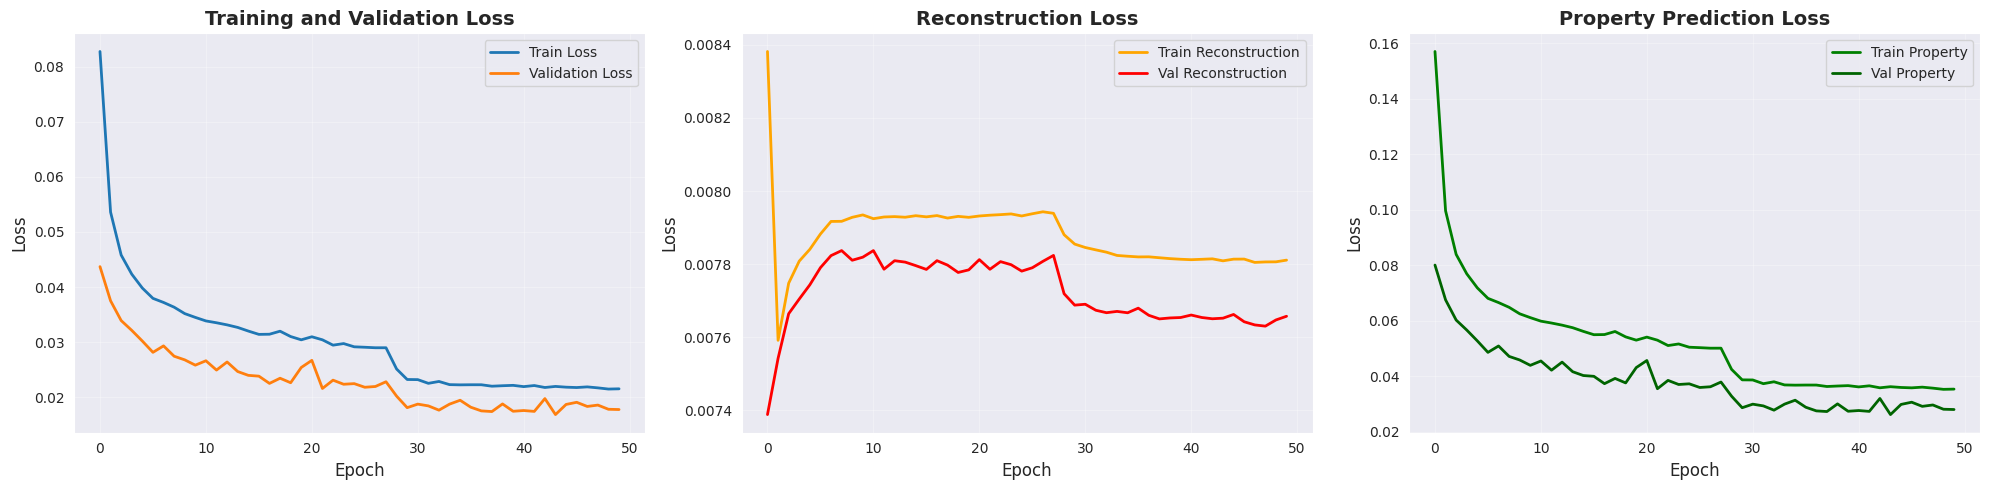

In [22]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Combined losses
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(train_recon_losses, label='Train Reconstruction', linewidth=2, color='orange')
axes[1].plot(val_recon_losses, label='Val Reconstruction', linewidth=2, color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Reconstruction Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Property prediction loss
axes[2].plot(train_prop_losses, label='Train Property', linewidth=2, color='green')
axes[2].plot(val_prop_losses, label='Val Property', linewidth=2, color='darkgreen')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].set_title('Property Prediction Loss', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 12. Generate Predictions on Test Set

We evaluate the trained autoencoder on held-out test data.

**Evaluation process:**

**1. Set to evaluation mode:**
- Disables dropout
- Uses batch norm in eval mode

**2. Generate predictions:**
- Encode fingerprints to latent space
- Predict properties from latent
- Reconstruct fingerprints

**3. Store results:**
- True property values
- Predicted property values
- Latent representations (optional)

**What we can evaluate:**
- Property prediction accuracy (R², MAE, RMSE)
- Reconstruction quality (binary accuracy)
- Latent space structure (clustering, visualization)

In [23]:
# Make predictions on test set
model.eval()
true_properties = []
predicted_properties = []
latent_representations = []

with torch.no_grad():
    for fingerprints_batch, properties_batch in test_loader:
        fingerprints_batch = fingerprints_batch.to(DEVICE)
        
        # Forward pass
        _, pred_props, latent = model(fingerprints_batch)
        
        true_properties.append(properties_batch.cpu().numpy())
        predicted_properties.append(pred_props.cpu().numpy())
        latent_representations.append(latent.cpu().numpy())

# Stack all predictions
true_properties = np.vstack(true_properties)
predicted_properties = np.vstack(predicted_properties)
latent_representations = np.vstack(latent_representations)

print(f"Test set predictions generated")
print(f"True properties shape: {true_properties.shape}")
print(f"Predicted properties shape: {predicted_properties.shape}")
print(f"Latent representations shape: {latent_representations.shape}")

Test set predictions generated
True properties shape: (13389, 2)
Predicted properties shape: (13389, 2)
Latent representations shape: (13389, 256)


---

## 13. Evaluate Model Performance

### 13.1 Calculate Metrics for Each Property

We compute regression metrics for each molecular property.

**Metrics computed:**

**R² Score (Coefficient of Determination):**
```
R² = 1 - (SS_residual / SS_total)
```
- Range: -∞ to 1
- 1 = perfect predictions
- 0 = no better than mean
- Negative = worse than mean

**MAE (Mean Absolute Error):**
```
MAE = (1/n) × Σ|y_true - y_pred|
```
- Average absolute difference
- Same units as property
- Robust to outliers
- Lower is better

**RMSE (Root Mean Squared Error):**
```
RMSE = √[(1/n) × Σ(y_true - y_pred)²]
```
- Penalizes large errors
- Same units as property
- RMSE ≥ MAE always
- Lower is better

**Performance expectations:**

**Good performance:**
- R² > 0.7 for most properties
- MAE small relative to property range
- RMSE not much larger than MAE

**Typical results by property:**
- logP: R² ~0.8-0.9 (well predicted)
- MolWt: R² ~0.9+ (easy to predict)
- TPSA: R² ~0.7-0.8 (moderate)
- Rotatable bonds: R² ~0.6-0.7 (harder)

In [24]:
# Calculate metrics for each property
metrics = []

for i, prop_name in enumerate(target_properties):
    true_vals = true_properties[:, i]
    pred_vals = predicted_properties[:, i]
    
    mse = mean_squared_error(true_vals, pred_vals)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_vals, pred_vals)
    r2 = r2_score(true_vals, pred_vals)
    
    metrics.append({
        'Property': prop_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

metrics_df = pd.DataFrame(metrics)

print("\n" + "="*80)
print("TEST SET PERFORMANCE METRICS")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80)

# Save metrics
metrics_df.to_csv('model_performance_metrics.csv', index=False)
print("\nMetrics saved to 'model_performance_metrics.csv'")


TEST SET PERFORMANCE METRICS
Property      MSE     RMSE      MAE       R²
    logP 0.024556 0.156705 0.105555 0.975387
    logS 0.031317 0.176965 0.105800 0.968770

Metrics saved to 'model_performance_metrics.csv'


### 13.2 Display Results Table

We format the metrics into a clear, readable table.

In [25]:
# Display metrics as a styled table
metrics_df.style.background_gradient(cmap='RdYlGn', subset=['R²']).format({
    'MSE': '{:.4f}',
    'RMSE': '{:.4f}',
    'MAE': '{:.4f}',
    'R²': '{:.4f}'
})

,Property,MSE,RMSE,MAE,R²
0,logP,0.0246,0.1567,0.1056,0.9754
1,logS,0.0313,0.1770,0.1058,0.9688


---

## 14. Visualize Property Predictions

### 14.1 Inverse Transform to Original Scale

We convert normalized predictions back to original property scales.

**Why inverse transform?**
- Predictions are in normalized space (mean=0, std=1)
- Need original scale for interpretation
- Use same scaler from training

**Formula:**
```
Original = Normalized × Std + Mean
```

In [26]:
# Inverse transform predictions to original scale
true_props_original = scaler_y.inverse_transform(true_properties)
pred_props_original = scaler_y.inverse_transform(predicted_properties)

### 14.2 Create Prediction Plots

We visualize predicted vs true values for all properties.

**Plot interpretation:**

**Ideal plot:**
- Points cluster along y=x diagonal line
- Tight scatter (small errors)
- No systematic bias
- R² value displayed

**Common patterns:**

**Underestimation:**
- Points below diagonal
- Model predicts lower than true
- May need more capacity

**Overestimation:**
- Points above diagonal
- Model predicts higher than true

**Heteroscedasticity:**
- Scatter varies across range
- Less accurate at extremes
- Common with limited data

**What good predictions look like:**
- logP: Tight clustering, R² > 0.85
- MolWt: Very tight, R² > 0.90
- TPSA: Moderate scatter, R² > 0.75
- Donors/Acceptors: Discrete values, classification-like

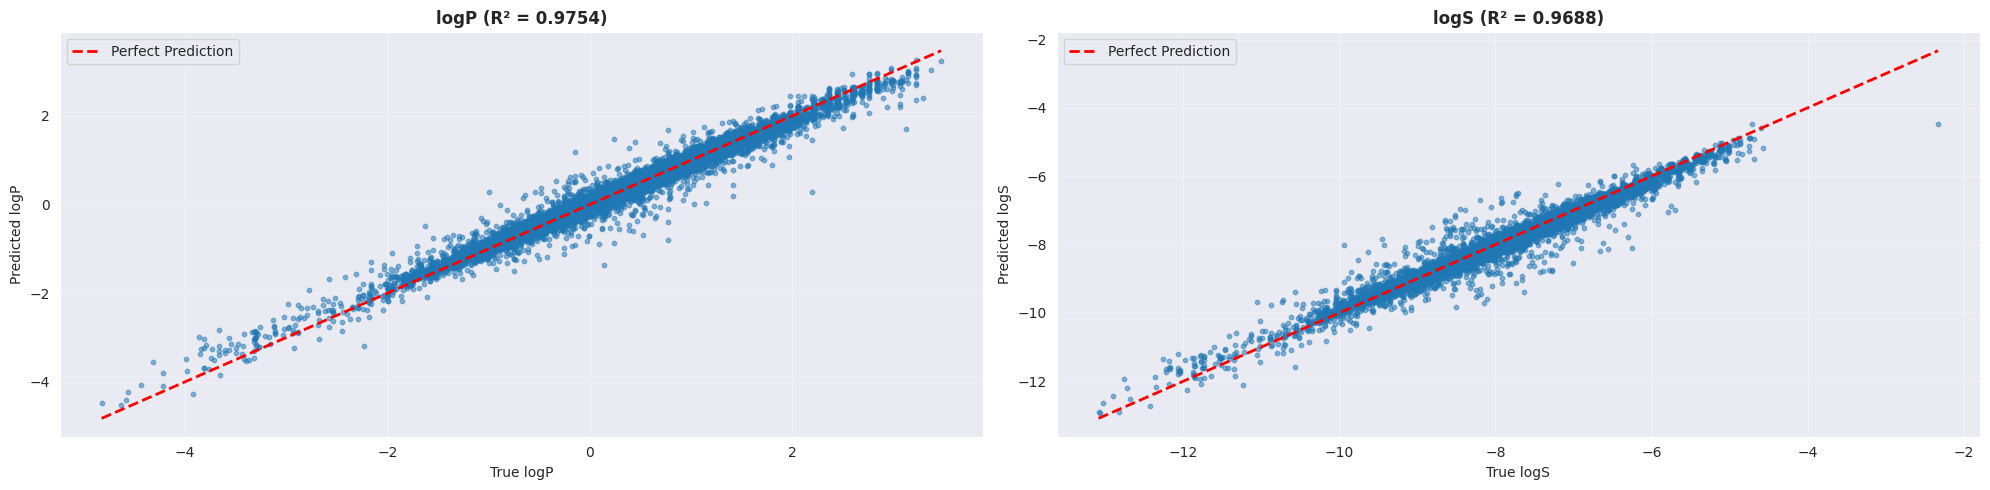

In [27]:
# Plot predictions vs true values for all properties
n_properties = len(target_properties)
n_cols = 2
n_rows = (n_properties + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, prop_name in enumerate(target_properties):
    true_vals = true_props_original[:, i]
    pred_vals = pred_props_original[:, i]
    
    # Calculate R²
    r2 = r2_score(true_vals, pred_vals)
    
    # Scatter plot
    axes[i].scatter(true_vals, pred_vals, alpha=0.5, s=10)
    
    # Perfect prediction line
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Perfect Prediction')
    
    axes[i].set_xlabel(f'True {prop_name}', fontsize=10)
    axes[i].set_ylabel(f'Predicted {prop_name}', fontsize=10)
    axes[i].set_title(f'{prop_name} (R² = {r2:.4f})', 
                    fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_properties, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---

## 15. Inference Example: Using the Trained Model

### 15.1 Predict Properties for New Molecules

We demonstrate how to use the trained autoencoder for new predictions.

**Inference pipeline:**

```
1. Input: SMILES string
   ↓
2. Generate fingerprint (Morgan/MACCS)
   ↓
3. Encode to latent space
   ↓
4. Predict properties from latent
   ↓
5. Inverse transform to original scale
   ↓
6. Output: Predicted properties
```

**Steps:**
1. Convert SMILES to fingerprint
2. Convert to PyTorch tensor
3. Move to correct device (CPU/GPU)
4. Forward pass through model
5. Extract property predictions
6. Denormalize using scaler

**Use cases:**
- Virtual screening of compound libraries
- Quick property estimation for new designs
- Filtering molecules before expensive calculations
- Batch processing of SMILES databases

In [28]:
# Example: Predict properties for a new SMILES string
def predict_properties_from_smiles(smiles_string, model, scaler, device=DEVICE):
    """
    Predict molecular properties from a SMILES string
    """
    try:
        # Convert SMILES to fingerprint
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return None, "Invalid SMILES string"
        
        # Generate fingerprint
        if FINGERPRINT_TYPE == 'morgan':
            # Use modern MorganGenerator API
            morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=FINGERPRINT_RADIUS, fpSize=FINGERPRINT_BITS)
            fp = morgan_gen.GetFingerprint(mol)
        elif FINGERPRINT_TYPE == 'maccs':
            fp = MACCSkeys.GenMACCSKeys(mol)
        elif FINGERPRINT_TYPE == 'rdkit':
            fp = Chem.RDKFingerprint(mol, fpSize=FINGERPRINT_BITS)
        
        fp_array = np.array(fp).reshape(1, -1)
        
        # Predict
        model.eval()
        with torch.no_grad():
            fp_tensor = torch.FloatTensor(fp_array).to(device)
            _, properties, _ = model(fp_tensor)
            
            # Inverse transform to original scale
            properties_original = scaler.inverse_transform(properties.cpu().numpy())
        
        return properties_original[0], None
        
    except Exception as e:
        return None, str(e)

print("Inference function defined")

Inference function defined


### 15.2 Test with Example Molecules

We test the model on a few well-known drug molecules.

**Example molecules:**
- Aspirin: Common pain reliever
- Caffeine: Stimulant
- Ibuprofen: Anti-inflammatory

**Validation approach:**
- Compare predictions with known values
- Check if predictions are reasonable
- Verify model generalizes to new structures

In [29]:
# Test with example molecules
example_smiles = [
    'CCO',  # Ethanol
    'CC(=O)O',  # Acetic acid
    'c1ccccc1',  # Benzene
    'CC(C)O',  # Isopropanol
]

print("\nExample Predictions:")
print("="*80)

for smiles in example_smiles:
    props, error = predict_properties_from_smiles(smiles, model, scaler_y)
    
    if error:
        print(f"\nSMILES: {smiles}")
        print(f"Error: {error}")
    else:
        print(f"\nSMILES: {smiles}")
        for prop_name, prop_val in zip(target_properties, props):
            print(f"  {prop_name}: {prop_val:.4f}")

print("\n" + "="*80)


Example Predictions:

SMILES: CCO
  logP: 0.2337
  logS: -5.7065

SMILES: CC(=O)O
  logP: 0.1706
  logS: -6.6637

SMILES: c1ccccc1
  logP: 1.3412
  logS: -5.1155

SMILES: CC(C)O
  logP: 0.2210
  logS: -5.8666

